In [2]:
import obspy
import torch
import glob
import copy
import numpy as np
import os
import noise_func
from matplotlib.colors import LinearSegmentedColormap
from obspy.geodetics.base import gps2dist_azimuth
from obspy.signal.rotate import rotate_ne_rt
from multiprocessing import Pool, Manager, Lock

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

tau_len = 15  # correlation shifting length - investigation depth
sampling_rate = 50  # resampling rate of data
dt = 1 / sampling_rate
shift = round(tau_len/dt)
tau = np.arange(shift+1) * dt

H = 1  # km
M = 1  # km

data_path = "/net/sb/data1/BASIN/SB1/TIMEdir50/"

In [3]:
# Correlation periods
all = glob.glob(data_path+"*/*.*.BHE.sac")
period = list(set([one[34:44] for one in all]))
period = noise_func.sort_datetime(period)
        
all_data = glob.glob(data_path+"{}/{}0000.*.BHE.sac".format(period[24*7], period[24*7]))  ##
station_nums = [trace[-12:-8] for trace in all_data]
nsts = len(station_nums)
lats = []
lons = []

for num in station_nums:
    filename = data_path + "{}/{}0000.{}.BHE.sac".format(period[24*7], period[24*7], num) 
    st = copy.deepcopy(obspy.read(filename)[0])
    lats.append(st.stats.sac.stla)
    lons.append(st.stats.sac.stlo)

station_nums = np.array(station_nums)
lats = torch.from_numpy(np.array(lats))  # (nstations,)
lons = torch.from_numpy(np.array(lons))  # (nstations,)
# Convert lats and longs to x (km)
xs = torch.zeros_like(lats)
ori = np.argmin(lons)  # from W to E
xs[ori] = 0 
for i in range(xs.size(0)):
    xs[i] = gps2dist_azimuth(lats[i], lons[i], lats[ori], lons[ori])[0] / 1000

assert xs[ori] == 0 

# rearrange the data following ascending 0rder of x
order = torch.argsort(xs)
xs = xs[order]
lats = lats[order]
lons = lons[order]
station_nums = station_nums[order]

# Set correlation pairs (H) and stacking traces (M)
dist = torch.zeros(nsts, nsts)  # in km
ba = torch.zeros(nsts, nsts)
for i in range(nsts):
    for j in range(nsts):
        dist[i, j], _, ba[i, j] = gps2dist_azimuth(lats[i], lons[i], lats[j], lons[j])
        dist[i, j] /= 1000

if_cc = dist <= H
# only calculate one side of symmetric matrix for computing efficiency
if_cc[np.tril_indices(if_cc.shape[0], -1)] = 0
ncc = if_cc.sum().item()
isrc_cc, irec_cc = torch.where(if_cc)

/tmp/ipykernel_1850530/1964969303.py:26: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  xs[i] = gps2dist_azimuth(lats[i], lons[i], lats[ori], lons[ori])[0] / 1000
/tmp/ipykernel_1850530/1964969303.py:42: DeprecationWarning: `alltrue` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `all` instead.
  dist[i, j], _, ba[i, j] = gps2dist_azimuth(lats[i], lons[i], lats[j], lons[j])


In [3]:
CC = Manager().list(torch.zeros(ncc, shift+1))
corrlen = Manager().list(torch.zeros(ncc))
lock = Lock()

def process(cc_indices):
    global CC, corrlen, lock
    for ip in period[24:-24*3]:  # skipping the first and last few days
        for icc in cc_indices:
            try:
                src_sta, rec_sta = station_nums[isrc_cc[icc]], station_nums[irec_cc[icc]]
                filename = data_path + "{}/{}0000.{}.BHN.sac".format(ip, ip, src_sta)
                st_src_n = obspy.read(filename)[0]
                filename = data_path + "{}/{}0000.{}.BHE.sac".format(ip, ip, src_sta)
                st_src_e = obspy.read(filename)[0]
                filename = data_path + "{}/{}0000.{}.BHN.sac".format(ip, ip, rec_sta)
                st_rec_n = obspy.read(filename)[0]
                filename = data_path + "{}/{}0000.{}.BHE.sac".format(ip, ip, rec_sta)
                st_rec_e = obspy.read(filename)[0]

                # rotate ne to rt
                if src_sta != rec_sta:  # do not rotate for autocorrelation
                    data_r_src, data_t_src = rotate_ne_rt(st_src_n.data, st_src_e.data, ba[isrc_cc[icc], irec_cc[icc]])
                    data_r_rec, data_t_rec = rotate_ne_rt(st_rec_n.data, st_rec_e.data, ba[isrc_cc[icc], irec_cc[icc]])
                else:
                    data_r_src, data_t_src = st_src_n.data, st_src_e.data
                    data_r_rec, data_t_rec = st_rec_n.data, st_rec_e.data
                
                corr = noise_func.data_processing(data_t_src, data_t_rec, freqmin=0.1, freqmax=1, whiten_window=0.5, fs=sampling_rate, shift=shift)
                if np.isnan(corr).sum() == 0:                
                    CC[icc] += corr
                    corrlen[icc] += 1
            except:
                pass
            
nproc = 10
nchunk = ncc // nproc
chunks = [range(i*nchunk, (i+1)*nchunk) for i in range(nproc)]
if ncc % nproc != 0:
    chunks.append(range(nproc*nchunk, ncc))
    nproc += 1

with Pool(processes=nproc) as p:
    p.map(process, chunks)

CC = torch.stack([item for item in CC], dim=0)
corrlen = torch.tensor(corrlen)
CC = CC / corrlen.unsqueeze(1)

In [ ]:
# stacking within M
ACF = torch.zeros(nsts, shift+1)
nstack = np.zeros(nsts)
for i in range(nsts):
    for icc in range(ncc):
        src_lat, rec_lat = lats[isrc_cc[icc]], lats[irec_cc[icc]]
        src_lon, rec_lon = lons[isrc_cc[icc]], lons[irec_cc[icc]]
        midlat = (src_lat + rec_lat) / 2
        midlon = (src_lon + rec_lon) / 2 
        d = gps2dist_azimuth(lats[i], lons[i], midlat, midlon)[0] / 1000
        if d <= M:
            ACF[i] += CC[icc]
            nstack[i] += 1

ACF = ACF / nstack.reshape(-1, 1)
ACF = noise_func.normalize_by_trace(ACF)

In [ ]:
A_avr = ACF.mean(dim=0)
R = ACF - A_avr
R = noise_func.normalize_by_trace(R)

In [ ]:
np.save("noise_acf_SB1_TT_H{}M{}.npy".format(H, M), R)

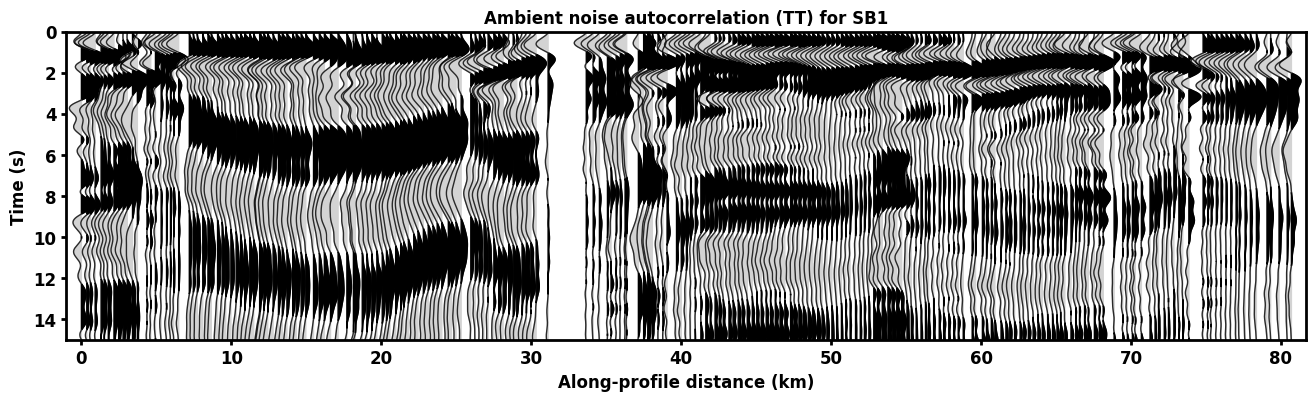

In [7]:
noise_func.section_plot(record=R, xs=xs, ts=tau, title="Ambient noise autocorrelation (TT) for SB1",
                        scale=0.8, save=True, figname="noise_example.png", fillcolors=('k', '#D3D3D3'), figsize=(16, 4))